In [10]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cvxpy as cp
from util import LoadData, generate_date_list, start, end, factors_list
from Optimizers import Optimizers, GetOptimalAllocation
from FactorModelling import GetParameterEstimates

ModuleNotFoundError: No module named 'util'

In [1]:
def generate_date_list(data, start, end):
    start = datetime.fromisoformat(start)
    end = datetime.fromisoformat(end)

    # Train model from start_date to date
    mask = (data['date'] >= start) & (data['date'] <= end)
    data = data.loc[mask]
    return data.date.apply(lambda x: x.date()).unique().tolist()


In [83]:
prices

symbol,date,A,AAPL,ABB,ABT,ACN,ADBE,ADI,ADP,ADSK,...,WELL,WFC,WM,WMB,WPC,WTRG,WY,XEL,XOM,YUM
0,2006-01-03,23.96,2.67,10.19,18.98,29.30,38.52,36.70,36.74,42.75,...,34.55,31.90,30.67,19.48,25.74,22.05,66.64,18.57,58.47,16.80
1,2006-01-04,24.03,2.68,10.48,19.00,29.46,38.42,37.04,36.86,42.52,...,34.92,31.53,30.27,19.61,26.14,22.15,68.25,18.66,58.57,16.95
2,2006-01-05,24.66,2.66,10.55,19.25,29.68,38.07,38.22,36.55,41.87,...,35.64,31.50,30.39,19.40,27.20,22.31,67.65,18.65,58.28,17.67
3,2006-01-06,24.79,2.72,10.64,19.62,31.15,39.00,38.37,36.87,44.29,...,35.79,31.68,30.54,19.48,26.62,22.44,67.75,18.72,59.43,17.62
4,2006-01-09,24.71,2.72,10.95,20.35,31.06,38.38,38.91,36.77,43.64,...,36.30,31.67,31.04,19.79,27.00,22.50,67.59,18.67,59.40,17.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3770,2020-12-23,117.30,130.96,27.56,107.45,257.44,496.91,143.22,175.19,300.18,...,62.36,30.35,116.25,20.75,69.90,45.41,33.61,64.31,41.77,106.79
3771,2020-12-24,117.31,131.97,27.65,108.35,257.30,499.86,144.47,176.56,301.39,...,63.52,29.84,117.00,20.74,70.40,45.47,33.85,64.63,41.60,107.54
3772,2020-12-28,117.83,136.69,27.86,107.79,259.68,498.95,144.68,176.61,299.65,...,62.97,29.93,118.09,20.14,70.99,46.08,33.71,65.32,41.74,109.78
3773,2020-12-29,117.23,134.87,27.89,108.33,257.76,502.11,143.66,174.87,298.11,...,63.18,29.78,116.82,20.08,70.16,46.11,33.33,65.42,41.27,109.45


In [26]:
def LoadData(path_to_data, e2e=True):
    if e2e:
        path_to_returns = r'{}\asset_weekly_cross_asset.pkl'.format(path_to_data)
        path_to_prices = r'{}\assetprices_weekly.pkl'.format(path_to_data)
        path_to_factors = r'{}\factor_weekly_cross_asset.pkl'.format(path_to_data)

        returns = pd.read_pickle(path_to_returns)
        prices = pd.read_pickle(path_to_prices)
        factors = pd.read_pickle(path_to_factors)

        returns = returns.reset_index()
        prices = prices.reset_index()
        factors = factors.reset_index()

        factors = factors.rename(columns={"Date": "date"})

        assets_list = prices.columns.to_list()

        return returns, assets_list, prices, factors

    path_to_prices = r'{}\prices.csv'.format(path_to_data)
    path_to_factors = r'{}\3factors.csv'.format(path_to_data)

    prices = pd.read_csv(path_to_prices)
    factors = pd.read_csv(path_to_factors)

    assets_list = list(prices['symbol'].unique())

    assets_list_cleaned = [x for x in assets_list if str(x) != 'nan']

    pivot_prices = np.round(pd.pivot_table(prices, values='close', 
                                    index='date', 
                                    columns='symbol', 
                                    aggfunc=np.mean),2)
    pivot_prices = pivot_prices.reset_index()
    pivot_prices['date'] = pd.to_datetime(pivot_prices['date'])
    factors['date'] = pd.to_datetime(factors['Date'], format="%Y%m%d")

    pivot_prices = pivot_prices.set_index('date')
    returns = pivot_prices.pct_change()
    pivot_prices = pivot_prices.reset_index()
    returns = returns.reset_index()
    returns = returns.merge(factors, on='date', how='left')
    returns = returns.drop(['Date'], axis=1)
    returns = returns.dropna()

    return returns, assets_list_cleaned, pivot_prices, []


In [27]:
path_to_data = r"C:\Users\Rafay\Documents\thesis\ActualWork\e2e\cache"

In [8]:
holdings = pd.DataFrame(columns=['date']+assets_list_cleaned)
portVal = pd.DataFrame(columns=['date', 'Wealth'])

In [13]:
start, end = '2015-01-01', '2015-12-31'
factors_list = ['Mkt-RF', 'SMB', 'HML']

In [34]:
dates = generate_date_list(returns, start=start, end=end)
first = True
InitialValue=1000000
lookback = 30

In [51]:
first = True
returns, assets_list_cleaned, prices, factors = LoadData(path_to_data, e2e=True)
for date in dates:
    # Get Asset Prices for Today
    currentPrices = (prices[prices['date']==str(date)]
        .drop('date',axis=1)
        .values
        .flatten())
    
    # Update Portfolio Value
    if first:
        portVal.loc[len(portVal)] = [date] + [InitialValue]
        CurrentPortfolioValue = InitialValue
        first = False
    else:     
        CurrentPortfolioValue = np.dot(currentPrices,noShares)
        portVal.loc[len(portVal)] = [date] + [CurrentPortfolioValue]
        
    # We don't want the current date information, hence the lack of equality
    # Get last 30
    date = str(date)
    
    returns_lastn = returns[(returns['date'] < date)].tail(lookback)
    asset_returns = returns_lastn.drop('date', axis=1)

    factor_returns = factors[(factors['date'] < date)].tail(lookback)
    factor_returns = factor_returns.drop('date', axis=1)

    # net_train to get optimal delta
    # perform forward pass to get optimal portfolio

    mu, Q = GetParameterEstimates(asset_returns, factor_returns, log=False, bad=True)
    x = GetOptimalAllocation(mu, Q, opt_type)

    # Update Holdings
    holdings.loc[len(holdings)] = [date] + list(x)

    # Update shares held
    # 50% of 100k = 50k. If price is 100 we have 50,000/100=50 shares
    noShares = np.divide(x*CurrentPortfolioValue, currentPrices)
    print('Done {}'.format(date))
    break

portVal['date'] = pd.to_datetime(portVal['date'])
portVal = portVal.merge(returns[['date','RF']], how='left', on='date')

2015-01-02


NameError: name 'GetParameterEstimates' is not defined

In [120]:
returns2, assets_list_cleaned, prices2, factors2 = LoadData(path_to_data, e2e=True)
returns, assets_list_cleaned, prices, factors = LoadData(path_to_data, e2e=False)


<AxesSubplot:xlabel='date'>

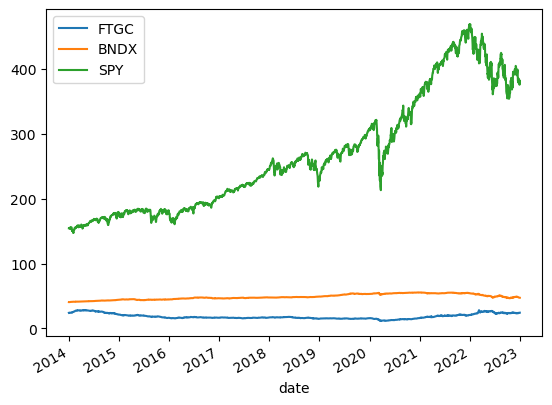

In [121]:
prices2.plot(x='date')

In [88]:
prices2[prices2['date']>'2015-03-27'].head(20)

,date,FTGC,BNDX,SPY,YINN
311,2015-03-30,19.677514,44.944099,179.857891,801.824857
312,2015-03-31,19.603428,45.044031,178.286024,785.690805
313,2015-04-01,19.799633,45.057355,177.655550,826.025935
314,2015-04-02,19.881046,44.973992,178.294661,850.789829
315,2015-04-06,20.027590,45.065691,179.495153,883.451904
316,2015-04-07,19.954318,45.032346,179.020138,890.562143
317,2015-04-08,19.718221,45.090700,179.624702,1056.029977
318,2015-04-09,19.628666,45.074027,180.419272,1179.099024
319,2015-04-10,19.726362,45.115708,181.403849,1155.460762
320,2015-04-13,19.620525,45.132381,180.583368,1192.794207


In [63]:
import torch

In [99]:
returns2

NameError: name 'returns2' is not defined

In [73]:
x = torch.tensor([[[0.2530],
         [0.2428],
         [0.2375],
         [0.2667]]], dtype=torch.float64)
y_hat = torch.tensor([ 0.3372,  0.2627,  0.3397, -0.0913], dtype=torch.float64)

In [82]:
def EW(mu, Q):
    n = len(mu)

    return np.ones(n) / n

[0.253, 0.2428, 0.2375, 0.2667]

In [108]:
def generate_date_list(data, data2, start, end):
    start = datetime.fromisoformat(start)
    end = datetime.fromisoformat(end)

    # Must be in this list
    must = data2.date.apply(lambda x: x.date()).unique().tolist()

    # Train model from start_date to date
    mask = (data['date'] >= start) & (data['date'] <= end) & data['date'].isin(must)

    data = data.loc[mask]
    return data.date.apply(lambda x: x.date()).unique().tolist()

In [109]:
returns2.date.apply(lambda x: x.date()).unique().tolist()

[datetime.date(2014, 1, 3),
 datetime.date(2014, 1, 10),
 datetime.date(2014, 1, 17),
 datetime.date(2014, 1, 24),
 datetime.date(2014, 1, 31),
 datetime.date(2014, 2, 7),
 datetime.date(2014, 2, 14),
 datetime.date(2014, 2, 21),
 datetime.date(2014, 2, 28),
 datetime.date(2014, 3, 7),
 datetime.date(2014, 3, 14),
 datetime.date(2014, 3, 21),
 datetime.date(2014, 3, 28),
 datetime.date(2014, 4, 4),
 datetime.date(2014, 4, 11),
 datetime.date(2014, 4, 18),
 datetime.date(2014, 4, 25),
 datetime.date(2014, 5, 2),
 datetime.date(2014, 5, 9),
 datetime.date(2014, 5, 16),
 datetime.date(2014, 5, 23),
 datetime.date(2014, 5, 30),
 datetime.date(2014, 6, 6),
 datetime.date(2014, 6, 13),
 datetime.date(2014, 6, 20),
 datetime.date(2014, 6, 27),
 datetime.date(2014, 7, 4),
 datetime.date(2014, 7, 11),
 datetime.date(2014, 7, 18),
 datetime.date(2014, 7, 25),
 datetime.date(2014, 8, 1),
 datetime.date(2014, 8, 8),
 datetime.date(2014, 8, 15),
 datetime.date(2014, 8, 22),
 datetime.date(2014, 8, 

In [106]:
generate_date_list(prices2, '2015-01-01', '2015-04-30')

[datetime.date(2015, 1, 2),
 datetime.date(2015, 1, 5),
 datetime.date(2015, 1, 6),
 datetime.date(2015, 1, 7),
 datetime.date(2015, 1, 8),
 datetime.date(2015, 1, 9),
 datetime.date(2015, 1, 12),
 datetime.date(2015, 1, 13),
 datetime.date(2015, 1, 14),
 datetime.date(2015, 1, 15),
 datetime.date(2015, 1, 16),
 datetime.date(2015, 1, 20),
 datetime.date(2015, 1, 21),
 datetime.date(2015, 1, 22),
 datetime.date(2015, 1, 23),
 datetime.date(2015, 1, 26),
 datetime.date(2015, 1, 27),
 datetime.date(2015, 1, 28),
 datetime.date(2015, 1, 29),
 datetime.date(2015, 1, 30),
 datetime.date(2015, 2, 2),
 datetime.date(2015, 2, 3),
 datetime.date(2015, 2, 4),
 datetime.date(2015, 2, 5),
 datetime.date(2015, 2, 6),
 datetime.date(2015, 2, 9),
 datetime.date(2015, 2, 10),
 datetime.date(2015, 2, 11),
 datetime.date(2015, 2, 12),
 datetime.date(2015, 2, 13),
 datetime.date(2015, 2, 17),
 datetime.date(2015, 2, 18),
 datetime.date(2015, 2, 19),
 datetime.date(2015, 2, 20),
 datetime.date(2015, 2, 23

In [115]:
factors_list

['Mkt-RF', 'SMB', 'HML']

In [117]:
factors2[['date'] + factors_list]

,date,Mkt-RF,SMB,HML
0,2014-01-03,-0.008503,0.001590,0.002201
1,2014-01-10,0.006690,0.003977,-0.014351
2,2014-01-17,-0.001175,0.004805,-0.006908
3,2014-01-24,-0.025944,0.004387,-0.001517
4,2014-01-31,-0.004491,-0.008505,-0.000622
...,...,...,...,...
465,2022-12-02,0.012376,0.005966,-0.024994
466,2022-12-09,-0.037659,-0.013439,-0.005649
467,2022-12-16,-0.021099,0.002485,0.001968
468,2022-12-23,-0.003988,-0.003324,0.028856
